In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn import datasets
from math import sqrt

import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.optimize as opt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_style("ticks")
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

## Data Split

In [3]:
anemia_df = pd.read_csv('../data/clean/anemia_bootstraped.csv', index_col=False)
x_values = anemia_df.drop(columns=["ANEMIA"])
x_values = anemia_df[['INTP', 'SEXO', 'EST_URB', 'EST_MARG', 'HB']]
y_values = anemia_df["ANEMIA"]
print(anemia_df.shape)

(200, 16)


In [4]:
# Data Split
from sklearn.model_selection import train_test_split
seed = 1234
x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.3, random_state=seed)

## Metrics Used

In [5]:
def print_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred=y_pred)
    sns.heatmap(cm, annot=True)
    target_names = ['0', '1']
    print(classification_report(y_test, y_pred, target_names=target_names))
    print('Accuracy: {0}'.format(accuracy_score(y_test, y_pred)))
    
def plot_roc(y_test, y_pred, model):
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.plot(fpr, tpr, marker='.', label = 'AUC: %0.2f' % auc, color= 'green')
    plt.title('{0} (ROC + AUC)'.format(model))
    plt.xlabel('False Positive Rate (x)')
    plt.ylabel('True Positive Rate (y)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

## Random Forest (No Normalized)

              precision    recall  f1-score   support

           0       0.96      0.82      0.88        28
           1       0.86      0.97      0.91        32

   micro avg       0.90      0.90      0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.91      0.90      0.90        60

Accuracy: 0.9


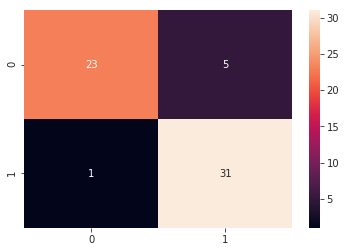

In [6]:
lr_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
print_metrics(y_test, y_pred)

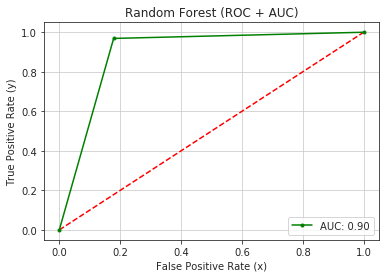

In [7]:
plot_roc(y_test, y_pred, 'Random Forest')

## Random Forest (Normalized Z-Score)

In [8]:
from sklearn import preprocessing
from scipy.stats import zscore
anemia_ndf = anemia_df.drop(columns=["ANEMIA"]).apply(zscore)
anemia_ndf['ANEMIA'] = anemia_df['ANEMIA']
anemia_ndf.head()

,INTP,ENTIDAD,MUNICI,LOCALI,ALTITUD,SEXO,EDADDIAS,EST_URB,EST_MARG,PONDEF,AREA,REGION,INDICEF,AFILIACI,HB,ANEMIA
0,-0.505004,1.523400,-0.257791,-0.200305,1.053404,-0.990050,-1.332723,-1.170328,1.105542,-0.419917,1.304877,1.217192,0.177599,-1.062059,0.144413,0.0
1,-0.972600,0.102428,-0.577631,-0.261356,-0.254913,-0.990050,0.146256,-0.022948,1.105542,-0.656073,-0.766356,-0.509321,-0.234795,0.848119,0.686810,0.0
2,2.768169,-1.081715,-0.257791,-0.072100,1.188631,-0.990050,1.155080,-1.170328,1.105542,-0.128654,1.304877,1.217192,0.133070,0.848119,1.093608,0.0
3,-0.505004,1.404986,-0.321759,0.019475,-0.929920,1.010051,0.793605,-1.170328,1.105542,-0.611524,1.304877,-1.372578,-1.235858,0.848119,0.144413,0.0
4,-0.505004,0.102428,-0.513663,-0.267461,0.276978,1.010051,1.703201,1.124433,-0.904534,0.215062,-0.766356,-0.509321,-0.189841,-1.444095,-0.262385,1.0


In [9]:
nx_values = anemia_ndf.drop(columns=['ANEMIA']) 
ny_values = anemia_ndf['ANEMIA']
nx_train, nx_test, ny_train, ny_test = train_test_split(nx_values, ny_values, test_size=0.3, random_state=seed)

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        28
           1       0.86      1.00      0.93        32

   micro avg       0.92      0.92      0.92        60
   macro avg       0.93      0.91      0.91        60
weighted avg       0.93      0.92      0.92        60

Accuracy: 0.9166666666666666


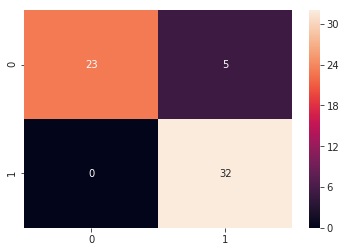

In [10]:
lr_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
lr_model.fit(nx_train, ny_train)
ny_pred = lr_model.predict(nx_test)
print_metrics(ny_test, ny_pred)

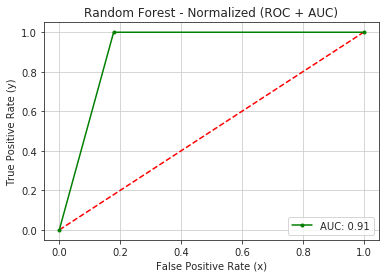

In [11]:
plot_roc(ny_test, ny_pred, 'Random Forest - Normalized')

# Learning Curves

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

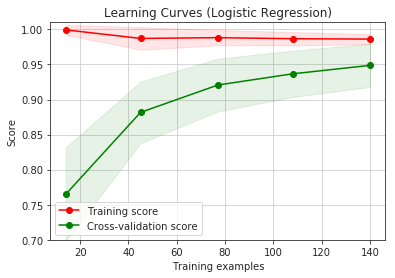

In [26]:
from sklearn.linear_model import LogisticRegression

title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 30% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=0)

estimator = LogisticRegression()
plot_learning_curve(estimator, title, nx_values, ny_values, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

[]

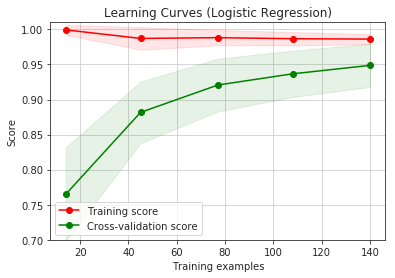

In [27]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=0)

estimator = LogisticRegression()
plot_learning_curve(estimator, title, nx_values, ny_values, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.plot()

[]

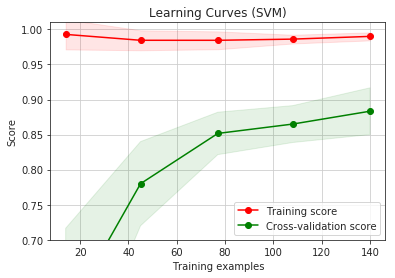

In [29]:

title = r"Learning Curves (SVM)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)


estimator = SVC()
plot_learning_curve(estimator, title, nx_values, ny_values, (0.7, 1.01), cv=cv, n_jobs=4)
plt.plot()